In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3

import pandas as pd

prefix = "binaryoptimization/maxcut"
# prefix = "discreteoptimization/tsp"
# prefix = "binaryoptimization/max3sat/satlib"

clauses = [
    f"`hid` LIKE '{prefix}%'",
    "`trotterization` = 'suzuki_trotter'",
    "`n_timesteps` = 1",
    "`order` = 4",
    "`n_qubits` >= 8",
    "`n_qubits` <= 127",
    "`n_terms` >= 8",
    "`n_terms` <= 256",
]
query = "SELECT * FROM `results` WHERE " + " AND ".join(clauses)

with sqlite3.connect("out/reorder.hcs=m/results.db") as db:
    df = pd.read_sql(query, db)

df.dropna(inplace=True)
df["time"] = df["reordering_time"] + df["synthesis_time"]
df.drop(["reordering_time", "synthesis_time"], axis=1, inplace=True)

# one how per (hid, method)
df = df.loc[df.groupby(["hid", "method"])["depth"].idxmin()]

df["problem_group"] = df["hid"].map(lambda hid: "/".join(hid.split("/")[:3]))
df = df.astype(
    {"n_terms": int, "depth": int, "n_timesteps": int, "order": int, "n_qubits": int}
)

df

,hid,method,n_terms,n_qubits,n_timesteps,order,trotterization,depth,jid,time,problem_group
66467,binaryoptimization/maxcut/biqmac/ising-hams/1-...,misra_gries,45,82,1,4,suzuki_trotter,90,62b30478f844592cb2ff43b34defb1d5893d3bdf,6.269,binaryoptimization/maxcut/biqmac
75045,binaryoptimization/maxcut/biqmac/ising-hams/1-...,none,45,82,1,4,suzuki_trotter,165,927aaf865295cdd680e0617f0089bdc62c171726,3.471,binaryoptimization/maxcut/biqmac
171261,binaryoptimization/maxcut/biqmac/ising-hams/1-...,saturation,45,82,1,4,suzuki_trotter,90,e055be9450f0f6e679b15fda2a0de8b00c83f639,5.746,binaryoptimization/maxcut/biqmac
36248,binaryoptimization/maxcut/biqmac/ising-hams/1-...,misra_gries,66,93,1,4,suzuki_trotter,110,482a95852437f2e45e210700401accb04b040ce9,9.784,binaryoptimization/maxcut/biqmac
20358,binaryoptimization/maxcut/biqmac/ising-hams/1-...,none,66,93,1,4,suzuki_trotter,205,d55cb29d6f394d2acad21efa8fa5577c309cd425,5.069,binaryoptimization/maxcut/biqmac
...,...,...,...,...,...,...,...,...,...,...,...
65941,binaryoptimization/maxcut/random/ham-graph-sta...,none,8,9,1,4,suzuki_trotter,75,6270a35e65bdba9a3df11851817d6af8887d68ad,1.030,binaryoptimization/maxcut/random
166348,binaryoptimization/maxcut/random/ham-graph-sta...,saturation,8,9,1,4,suzuki_trotter,75,b5779e1629fe0c3e1687ebb817f13dcc35516289,1.532,binaryoptimization/maxcut/random
21273,binaryoptimization/maxcut/random/ham-graph-sta...,misra_gries,89,90,1,4,suzuki_trotter,885,cae20e809d4d6d009cbb5d74e0ead8a9398253b1,200.127,binaryoptimization/maxcut/random
71945,binaryoptimization/maxcut/random/ham-graph-sta...,none,89,90,1,4,suzuki_trotter,885,23add82e2a168678a38ac441d8ed2d49490ba39b,6.370,binaryoptimization/maxcut/random


In [3]:
# Add the time_pc and depth_pc colunms

dfp, lst = df.pivot(index="hid", columns="method"), []

for m in df["method"].unique():
    depth_pc = dfp["depth"][m] * 100 / (dfp["depth"]["none"] + 1e-3)
    time_pc = dfp["time"][m] * 100 / (dfp["time"]["none"] + 1e-3)
    lst.append(
        pd.DataFrame(
            {
                "method": m,
                "depth_pc": depth_pc,
                "depth_red_pc": 100 - depth_pc,
                "time_pc": time_pc,
            }
        )
    )

a = pd.concat(lst)
a = a.pivot(columns="method")
df = dfp.join(a).stack(future_stack=True).reset_index()

In [4]:
# Filter and remove outliers

from scipy.stats import zscore
import numpy as np

MAX_ZSCORE = 3

# x = df[["time", "n_terms", "depth", "time_pc"]].to_numpy()
x = df[["time", "time_pc"]].to_numpy()
p = (np.abs(zscore(x)) < MAX_ZSCORE).all(axis=1)
print("Dropping", len(df) - p.sum(), "rows")
df = df[p]
print("Left:   ", len(df))

Dropping 2490 rows
Left:    85200


In [5]:
def _print_col_stats(msg: str, s: pd.Series):
    d = s.describe()
    txt = f"count: {len(s)} | "
    txt += " | ".join(f"{k}: {v:>6.2f}" for k, v in zip(d.index, d) if k != "count")
    print(msg, "|", txt)


print("Unique Hamiltonians:", len(df["hid"].unique()))
d = df[df["method"] == "none"].groupby("hid").first().reset_index()
_print_col_stats("n_qubits", d["n_qubits"])
_print_col_stats("n_terms ", d["n_terms"])
_print_col_stats("depth   ", d["depth"])

print("--------------------------------------------------")

for method in df["method"].unique():
    if method == "none":
        continue
    print("Method:", method)
    d = df[df["method"] == method]
    _print_col_stats("    - Time %           ", d["time_pc"])
    _print_col_stats("    - Depth %          ", d["depth_pc"])
    _print_col_stats("    - Depth reduction %", d["depth_red_pc"])

print("--------------------------------------------------")

print("Unique problem groups:")
for pg in df["problem_group"].unique():
    print("   - ", pg)

Unique Hamiltonians: 29227
n_qubits | count: 28496 | mean:  77.15 | std:  27.44 | min:   8.00 | 25%:  60.00 | 50%:  87.00 | 75%:  99.00 | max: 127.00
n_terms  | count: 28496 | mean:  74.40 | std:  64.33 | min:   8.00 | 25%:  22.00 | 50%:  52.00 | 75%: 110.00 | max: 255.00
depth    | count: 28496 | mean: 186.81 | std: 115.23 | min:  30.00 | 25%:  95.00 | 50%: 155.00 | 75%: 255.00 | max: 2365.00
--------------------------------------------------
Method: misra_gries
    - Time %            | count: 28254 | mean: 186.36 | std:  50.59 | min:   3.02 | 25%: 163.98 | 50%: 181.06 | 75%: 208.42 | max: 609.08
    - Depth %           | count: 28254 | mean:  56.17 | std:  14.62 | min:   2.11 | 25%:  47.06 | 50%:  54.79 | 75%:  64.00 | max: 114.28
    - Depth reduction % | count: 28254 | mean:  43.83 | std:  14.62 | min: -14.28 | 25%:  36.00 | 50%:  45.21 | 75%:  52.94 | max:  97.89
Method: saturation
    - Time %            | count: 28450 | mean: 157.27 | std:  36.83 | min:   2.66 | 25%: 148.51 | 5

In [6]:
df_pretty = df.rename(
    columns={
        "method": "Coloring method",
        "n_terms": "Number of terms",
        "n_qubits": "Number of qubits",
        "n_timesteps": "Number of Trotterization timesteps",
        "order": "Suzuki-Trotter order",
        "depth": "Evolution circuit depth",
        "time": "Processing time",
        "depth_pc": "Evolution circuit depth (% of baseline)",
        "depth_red_pc": "Evolution circuit depth reduction (% of baseline)",
        "time_pc": "Processing time (% of baseline)",
        "trotterization": "Trotterization method",
    }
)
df_pretty = (
    df_pretty.set_index("Coloring method")
    .rename(
        index={
            "saturation": "Saturation on $G_{\\mathrm{overlap}}$",
            "misra_gries": "Misra-Gries on $G_{\\mathrm{inter.}}$",
            "none": "None",
        }
    )
    .reset_index()
)
df_pretty = (
    df_pretty.set_index("Trotterization method")
    .rename(
        index={
            "lie_trotter": "Lie-Trotter",
            "suzuki_trotter": "Suzuki-Trotter",
        }
    )
    .reset_index()
)

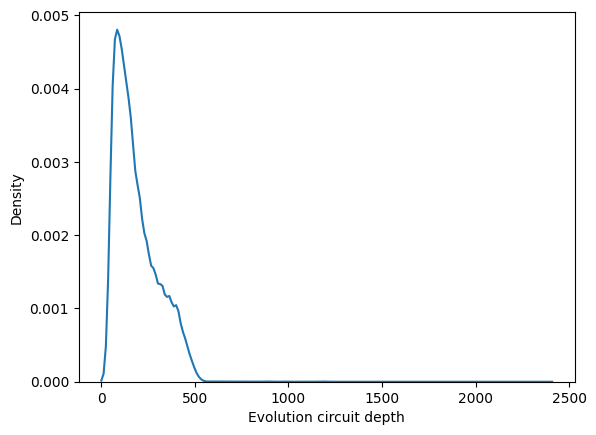

In [7]:
import seaborn as sns

_df = df_pretty.loc[df_pretty["Coloring method"] == "None"]
ax = sns.kdeplot(
    data=_df,
    x="Evolution circuit depth",
    clip=(0, None),
)

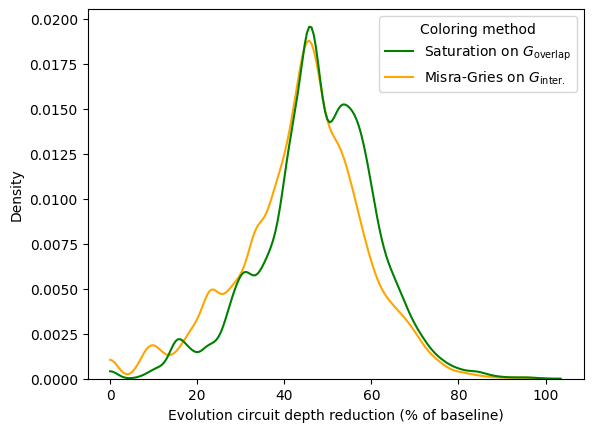

In [8]:
import seaborn as sns

_df = df_pretty.loc[df_pretty["Coloring method"] != "None"]
ax = sns.kdeplot(
    data=_df,
    x="Evolution circuit depth reduction (% of baseline)",
    hue="Coloring method",
    clip=(0, None),
    hue_order=[
        "Saturation on $G_{\\mathrm{overlap}}$",
        "Misra-Gries on $G_{\\mathrm{inter.}}$",
    ],
    palette={
        "Saturation on $G_{\\mathrm{overlap}}$": "green",
        "Misra-Gries on $G_{\\mathrm{inter.}}$": "orange",
    },
)

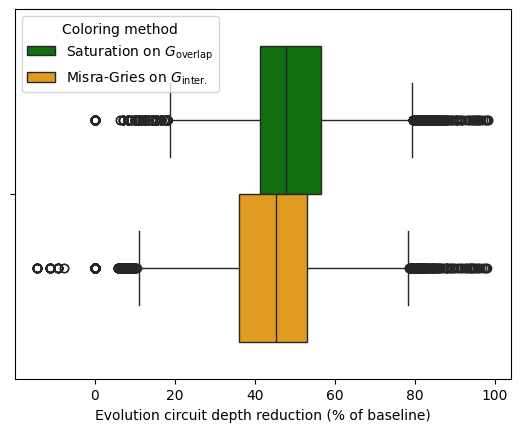

In [9]:
import seaborn as sns

_df = df_pretty.loc[df_pretty["Coloring method"] != "None"]
ax = sns.boxplot(
    data=_df,
    x="Evolution circuit depth reduction (% of baseline)",
    hue="Coloring method",
    hue_order=[
        "Saturation on $G_{\\mathrm{overlap}}$",
        "Misra-Gries on $G_{\\mathrm{inter.}}$",
    ],
    palette={
        "Saturation on $G_{\\mathrm{overlap}}$": "green",
        "Misra-Gries on $G_{\\mathrm{inter.}}$": "orange",
    },
)

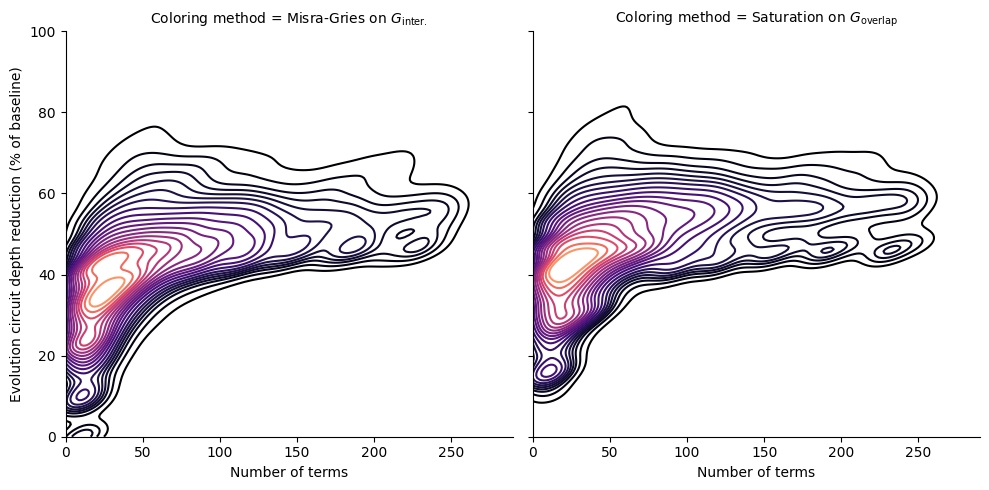

In [10]:
import seaborn as sns

_df = df_pretty[df_pretty["Coloring method"] != "None"]
xlim, ylim = (0, 300), (0, 100)

sns.displot(
    data=_df,
    x="Number of terms",
    y="Evolution circuit depth reduction (% of baseline)",
    col="Coloring method",
    kind="kde",
    cmap="magma",
    levels=20,
    clip=(xlim, ylim),
)

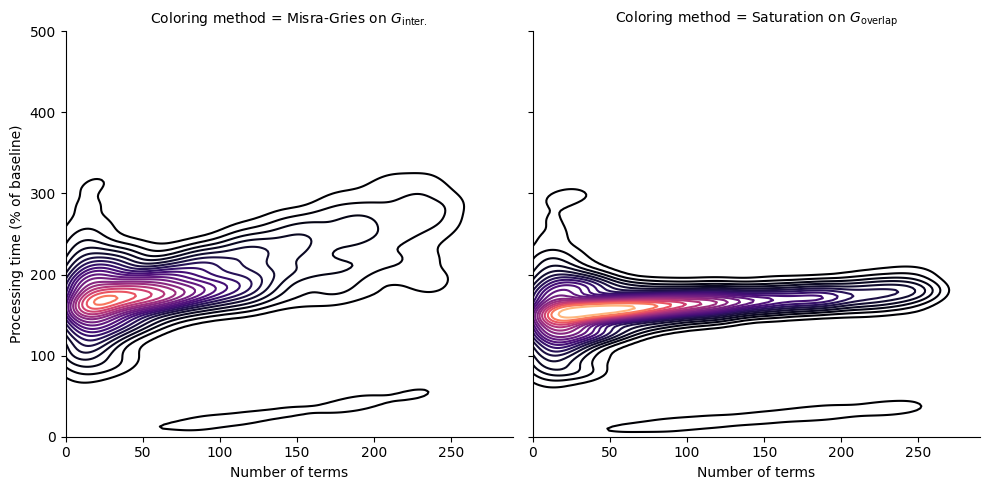

In [11]:
import seaborn as sns

_df = df_pretty[df_pretty["Coloring method"] != "None"]
xlim, ylim = (0, 300), (0, 500)

sns.displot(
    data=_df,
    x="Number of terms",
    y="Processing time (% of baseline)",
    col="Coloring method",
    kind="kde",
    cmap="magma",
    levels=20,
    clip=(xlim, ylim),
)